## Pre-processing

In [19]:
import tifffile as tiff
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
import os, shutil
import numpy as np
from pathlib import Path

#### Cellpose Denoise Model

In [ ]:
# USE cellposeDenoiseModel FRO DENOISING THE IMAGE
from cellpose import denoise
dn = denoise.DenoiseModel (model_type='denoise_cyto3', gpu=True, chan2=True)
imgs_dn = dn.eval(imgs, channels=[1,2], diameter=25.)


# RUN SEGMENTATION
masks, flows, styles = model.eval(imgs_dn, diameter=diameter, channels=channels, 
                                        cellprob_threshold=cellprob_threshold, 
                                        do_3D=True, anisotropy=1.5, min_size=1000)
# save output to *_seg.npy
io.masks_flows_to_seg(imgs_dn, 
                      masks, 
                      flows, 
                      files, 
                      channels=channels) 
#save output masks to tiffs/pngs or txt files for imageJ
io.save_masks(imgs_dn, 
              masks, 
              flows, 
              files, 
              channels=channels,
              png=True, # save masks as PNGs and save example image
              tif=True, # save masks as TIFFs
              save_txt=True, # save txt outlines for ImageJ
              save_flows=False, # save flows as TIFFs
              save_outlines=False, # save outlines as TIFFs 
              save_mpl=True # make matplotlib fig to view (WARNING: SLOW W/ LARGE IMAGES)
              )

2024-10-15 11:37:50,260 [INFO] >> denoise_cyto3 << model set to be used
2024-10-15 11:37:50,263 [INFO] ** TORCH CUDA version installed and working. **
2024-10-15 11:37:50,265 [INFO] >>>> using GPU
2024-10-15 11:37:50,580 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
loading model for chan2: denoise_nuclei
2024-10-15 11:37:50,961 [INFO] multi-stack tiff read in as having 240 planes 2 channels
2024-10-15 11:40:09,104 [INFO] 100%|##########| 240/240 [02:14<00:00,  1.78it/s]
2024-10-15 11:40:09,106 [INFO] imgs denoised in 134.67s
2024-10-15 11:40:09,421 [INFO] 0%|          | 0/240 [00:00<?, ?it/s]


c:\Users\fnarslan\AppData\Local\miniconda3\envs\cellpose-env\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


2024-10-15 11:46:41,126 [INFO] 100%|##########| 240/240 [06:31<00:00,  1.63s/it]
2024-10-15 11:46:41,128 [INFO] imgs denoised in 391.71s


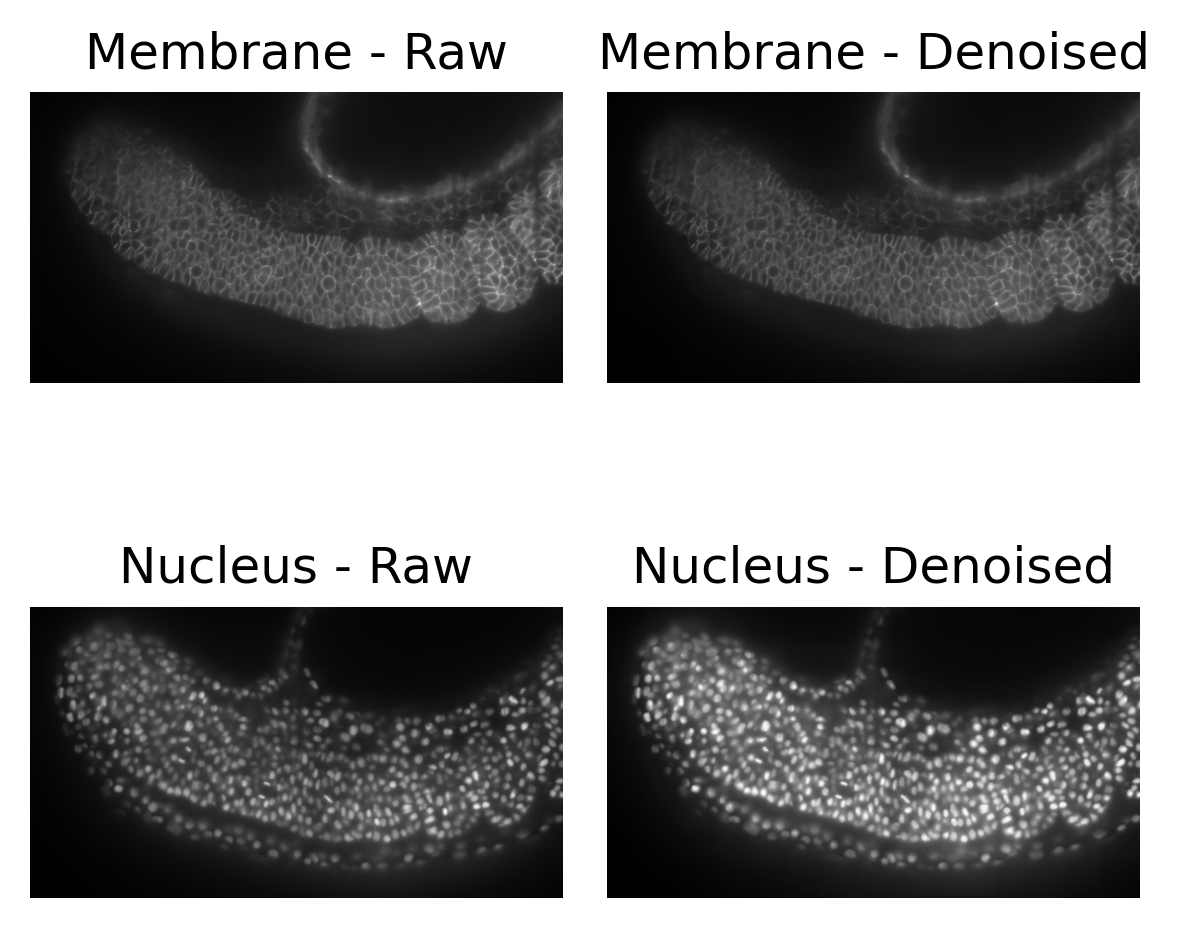

In [135]:
# compare raw and denoised image
stack = 120

fig, axes = plt.subplots(2, 2, figsize=(4, 4))

# Membrane raw image in top-left
axes[0, 0].imshow(imgs[stack][0], cmap='gray')
axes[0, 0].set_title('Membrane - Raw')
axes[0, 0].axis('off')

# Membrane denoised image in top-right
axes[0, 1].imshow(imgs_dn[stack,:,:,0], cmap='gray')
axes[0, 1].set_title('Membrane - Denoised')
axes[0, 1].axis('off')

# Nucleus raw image in bottom-left
axes[1, 0].imshow(imgs[stack][1], cmap='gray')
axes[1, 0].set_title('Nucleus - Raw')
axes[1, 0].axis('off')

# Nucleus denoised image in bottom-right
axes[1, 1].imshow(imgs_dn[stack,:,:,1], cmap='gray')
axes[1, 1].set_title('Nucleus - Denoised')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

### other preproc (tested at 3d_preproc)

In [131]:
print(f'Loaded image in an array of shape: {imgs_dn.shape} and data type {imgs_dn.dtype}')


Loaded image in an array of shape: (240, 708, 1294, 2) and data type float32


## Cellpose Segmentation


In [16]:
# activate cellpose-env
# to use GPU, first check on the terminal: 
!nvcc --version 
!nvidia-smi
# then turn use GPU to True

from cellpose import core, utils, io, models, metrics, plot
from cellpose.io import imread
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:36:24_Pacific_Standard_Time_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0
Tue Nov 19 09:39:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 5000              WDDM  |   00000000:D8:00.0 Off |                  Off |
| 33%

#### Run in a single image file

In [30]:
io.logger_setup()

### MODEl
#  Custom model path
# model_path = "H:/PROJECTS-03/Feyza/segmentation/cellpose_nuclei_membrane/training_data_05z/models/CP_20241007_h2bxncad"
# model = models.CellposeModel(gpu=True, 
#							 pretrained_model=model_path)

# or to run one of the other models, or a custom model, specify a CellposeModel
model = models.CellposeModel(model_type='cyto3')

### Path to images
imgs_path = "H:/PROJECTS-03/Feyza/240925-NcadGFPxH2Bch-HIGHRES/20240925_151619_20240925_NcadxH2B_05z_timelapse/3d_segmentation_test/pos4-t1-cropped-raw.tif"
imgs = imread(imgs_path)
nimg = len(imgs)
print(f'Loaded image in an array of shape: {imgs.shape} and data type {imgs.dtype}')

### PARAMETERS
# define channels
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
channels = [[1,2]]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

#save file name as
files = os.path.dirname(imgs_path) + "/" + "3d_segmentation_test_cp_masks_raw_cyto3"
			 


# Segmentation Parameters
diameter = 25 # in pixels
# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended)
# diameter can be a list or a single number for all images
cellprob_threshold = -1

masks, flows, styles = model.eval(imgs, diameter=diameter, channels=channels, 
										cellprob_threshold=cellprob_threshold, 
										do_3D=True, anisotropy=1.5, min_size=1000)

#if stitch_threshold>0.0 and not do_3D, masks are stitched in 3D to return volume segmentation



# save output to *_seg.npy
io.masks_flows_to_seg(imgs, 
					  masks, 
					  flows, 
					  files, 
					  channels=channels) 



#save output masks to tiffs/pngs or txt files for imageJ
io.save_masks(imgs, 
			  masks,
			  flows, 
			  files, 
			  channels=channels,
			  png=True, # save masks as PNGs and save example image
			  tif=True, # save masks as TIFFs
			  save_txt=True, # save txt outlines for ImageJ
			  save_flows=False, # save flows as TIFFs
			  save_outlines=False, # save outlines as TIFFs 
			  save_mpl=True # make matplotlib fig to view (WARNING: SLOW W/ LARGE IMAGES)
			  )



creating new log file
2024-11-19 17:39:18,672 [INFO] WRITING LOG OUTPUT TO C:\Users\fnarslan\.cellpose\run.log
2024-11-19 17:39:18,673 [INFO] 
cellpose version: 	3.1.0 
platform:       	win32 
python version: 	3.10.15 
torch version:  	2.5.1+cu124


2024-11-19 17:39:18,708 [INFO] >> cyto3 << model set to be used
2024-11-19 17:39:18,710 [INFO] >>>> using CPU
2024-11-19 17:39:18,711 [INFO] >>>> using CPU
2024-11-19 17:39:18,805 [INFO] >>>> loading model C:\Users\fnarslan\.cellpose\models\cyto3
2024-11-19 17:39:19,039 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


c:\Users\fnarslan\AppData\Local\miniconda3\envs\cellpose\lib\site-packages\cellpose\resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

2024-11-19 17:39:19,076 [INFO] reading tiff with 480 planes


100%|██████████| 480/480 [00:01<00:00, 320.40it/s]


Loaded image in an array of shape: (240, 2, 708, 1294) and data type uint16
2024-11-19 17:39:20,694 [INFO] multi-stack tiff read in as having 240 planes 2 channels
2024-11-19 17:39:23,157 [INFO] resizing 3D image with rescale=1.20 and anisotropy=1.5
2024-11-19 17:39:30,517 [INFO] running YX: 432 planes of size (849, 1552)
2024-11-19 18:15:09,215 [INFO] 100%|##########| 432/432 [35:38<00:00,  4.95s/it]
2024-11-19 18:15:16,725 [INFO] running ZY: 849 planes of size (432, 1552)
2024-11-19 18:57:31,284 [INFO] 100%|##########| 849/849 [42:14<00:00,  2.99s/it]
2024-11-19 18:57:36,490 [INFO] running ZX: 1552 planes of size (432, 849)
2024-11-19 19:41:10,153 [INFO] 100%|##########| 1552/1552 [43:33<00:00,  1.68s/it]
2024-11-19 19:41:37,068 [INFO] resizing 3D flows and cellprob to original image size
2024-11-19 19:41:48,483 [INFO] network run in 7345.33s
2024-11-19 20:03:48,985 [INFO] masks created in 1319.92s


#### Run in a folder of images

In [20]:
# Setup logging for Cellpose
io.logger_setup()

### MODEL
# Custom model path
model_path = "H:/PROJECTS-03/Feyza/segmentation/cellpose_nuclei_membrane/training_data_05z/models/CP_20241007_h2bxncad"

# Declare model
model = models.CellposeModel(gpu=True, pretrained_model=model_path)

### PARAMETERS
# Define channels
channels = [[1, 2]]  # cytoplasm: 1, nucleus: 2

# Segmentation parameters
diameter = 25  # in pixels
cellprob_threshold = -1

# Input folder containing images
input_folder = Path("H:/PROJECTS-03/Feyza/240925-NcadGFPxH2Bch-HIGHRES/20240925_151619_20240925_NcadxH2B_05z_timelapse/3d_segmentation_test")
output_folder = input_folder / "segmentation_results"
output_folder.mkdir(exist_ok=True)  # Create folder if it doesn't exist

# Process all files in the folder
for img_file in input_folder.glob("*.tif"):
    print(f"Processing file: {img_file.name}")

    # Read image
    imgs = imread(img_file)
    print(f'Loaded image {img_file.name} with shape: {imgs.shape} and data type {imgs.dtype}')

    # Generate output file name
    output_file_base = output_folder / img_file.stem  # Use the base name without extension

    # Perform segmentation
    masks, flows, styles = model.eval(
        imgs,
        diameter=diameter,
        channels=channels,
        cellprob_threshold=cellprob_threshold,
        do_3D=True,
        anisotropy=1.5,
        min_size=1000,
    )

    # Save output to *_seg.npy
    seg_file = str(output_file_base) + "_seg"
    io.masks_flows_to_seg(imgs, masks, flows, seg_file, channels=channels)

    # Save output masks to tiffs/pngs or txt files for ImageJ
    io.save_masks(
        imgs,
        masks,
        flows,
        str(output_file_base),
        channels=channels,
        png=True,  # Save masks as PNGs
        tif=True,  # Save masks as TIFFs
        save_txt=True,  # Save txt outlines for ImageJ
        save_flows=False,  # Save flows as TIFFs
        save_outlines=False,  # Save outlines as TIFFs
        save_mpl=True,  # Make matplotlib fig to view (WARNING: SLOW W/ LARGE IMAGES)
    )

    print(f"Saved results for {img_file.name} to {output_folder}")

print("All files processed.")


creating new log file
2024-11-19 09:51:49,049 [INFO] WRITING LOG OUTPUT TO C:\Users\fnarslan\.cellpose\run.log
2024-11-19 09:51:49,050 [INFO] 
cellpose version: 	3.1.0 
platform:       	win32 
python version: 	3.10.15 
torch version:  	2.5.1+cu124
2024-11-19 09:51:49,055 [INFO] ** TORCH CUDA version installed and working. **
2024-11-19 09:51:49,057 [INFO] >>>> using GPU (CUDA)


2024-11-19 09:51:49,206 [INFO] >>>> loading model H:/PROJECTS-03/Feyza/segmentation/cellpose_nuclei_membrane/training_data_05z/models/CP_20241007_h2bxncad
2024-11-19 09:51:49,349 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-11-19 09:51:49,350 [INFO] >>>> model diam_labels =  23.713 (mean diameter of training ROIs)
Processing file: pos4-t1-cropped-raw-bgsub-rad10.tif
2024-11-19 09:51:49,395 [INFO] reading tiff with 480 planes


100%|██████████| 480/480 [00:01<00:00, 301.14it/s]

Loaded image pos4-t1-cropped-raw-bgsub-rad10.tif with shape: (240, 2, 708, 1294) and data type uint16
2024-11-19 09:51:51,049 [INFO] multi-stack tiff read in as having 240 planes 2 channels


2024-11-19 09:51:53,638 [INFO] resizing 3D image with rescale=1.20 and anisotropy=1.5
2024-11-19 09:52:01,271 [INFO] running YX: 432 planes of size (849, 1552)
2024-11-19 09:55:18,933 [INFO] 100%|##########| 432/432 [03:17<00:00,  2.19it/s]
2024-11-19 09:55:26,001 [INFO] running ZY: 849 planes of size (432, 1552)
2024-11-19 09:59:05,883 [INFO] 100%|##########| 849/849 [03:39<00:00,  3.86it/s]
2024-11-19 09:59:11,522 [INFO] running ZX: 1552 planes of size (432, 849)
2024-11-19 10:03:25,864 [INFO] 100%|##########| 1552/1552 [04:14<00:00,  6.10it/s]
2024-11-19 10:03:51,141 [INFO] resizing 3D flows and cellprob to original image size
2024-11-19 10:04:02,591 [INFO] network run in 728.95s
2024-11-19 10:04:56,272 [INFO] masks created in 53.02s
Saved results for pos4-t1-cropped-raw-bgsub-rad10.tif to H:\PROJECTS-03\Feyza\240925-NcadGFPxH2Bch-HIGHRES\20240925_151619_20240925_NcadxH2B_05z_timelapse\3d_segmentation_test\segmentation_results
Processing file: pos4-t1-cropped-raw-medfilt2.tif
2024-1

100%|██████████| 480/480 [00:01<00:00, 293.93it/s]

Loaded image pos4-t1-cropped-raw-medfilt2.tif with shape: (240, 2, 708, 1294) and data type uint16
2024-11-19 10:06:04,797 [INFO] multi-stack tiff read in as having 240 planes 2 channels


2024-11-19 10:06:07,363 [INFO] resizing 3D image with rescale=1.20 and anisotropy=1.5
2024-11-19 10:06:15,253 [INFO] running YX: 432 planes of size (849, 1552)
2024-11-19 10:09:23,240 [INFO] 100%|##########| 432/432 [03:07<00:00,  2.30it/s]
2024-11-19 10:09:30,269 [INFO] running ZY: 849 planes of size (432, 1552)
2024-11-19 10:13:10,122 [INFO] 100%|##########| 849/849 [03:39<00:00,  3.86it/s]
2024-11-19 10:13:15,797 [INFO] running ZX: 1552 planes of size (432, 849)
2024-11-19 10:17:33,122 [INFO] 100%|##########| 1552/1552 [04:17<00:00,  6.03it/s]
2024-11-19 10:17:59,146 [INFO] resizing 3D flows and cellprob to original image size
2024-11-19 10:18:10,630 [INFO] network run in 723.27s
2024-11-19 10:18:52,693 [INFO] masks created in 41.49s
Saved results for pos4-t1-cropped-raw-medfilt2.tif to H:\PROJECTS-03\Feyza\240925-NcadGFPxH2Bch-HIGHRES\20240925_151619_20240925_NcadxH2B_05z_timelapse\3d_segmentation_test\segmentation_results
Processing file: pos4-t1-cropped-raw.tif
2024-11-19 10:19:5

100%|██████████| 480/480 [00:01<00:00, 344.83it/s]


Loaded image pos4-t1-cropped-raw.tif with shape: (240, 2, 708, 1294) and data type uint16
2024-11-19 10:19:57,635 [INFO] multi-stack tiff read in as having 240 planes 2 channels
2024-11-19 10:20:00,136 [INFO] resizing 3D image with rescale=1.20 and anisotropy=1.5
2024-11-19 10:20:08,200 [INFO] running YX: 432 planes of size (849, 1552)
2024-11-19 10:23:18,737 [INFO] 100%|##########| 432/432 [03:10<00:00,  2.27it/s]
2024-11-19 10:23:25,657 [INFO] running ZY: 849 planes of size (432, 1552)
2024-11-19 10:27:04,676 [INFO] 100%|##########| 849/849 [03:39<00:00,  3.88it/s]
2024-11-19 10:27:10,402 [INFO] running ZX: 1552 planes of size (432, 849)
2024-11-19 10:31:25,298 [INFO] 100%|##########| 1552/1552 [04:14<00:00,  6.09it/s]
2024-11-19 10:31:52,769 [INFO] resizing 3D flows and cellprob to original image size
2024-11-19 10:32:04,141 [INFO] network run in 724.01s
2024-11-19 10:32:52,601 [INFO] masks created in 47.73s
Saved results for pos4-t1-cropped-raw.tif to H:\PROJECTS-03\Feyza\240925-Nc

100%|██████████| 480/480 [00:01<00:00, 331.69it/s]

Loaded image pos4-t1-cropped-raw_clahe-clip5_bgsub-rad10_medfilt-rad1.tif with shape: (240, 2, 708, 1294) and data type uint16
2024-11-19 10:33:59,079 [INFO] multi-stack tiff read in as having 240 planes 2 channels


2024-11-19 10:34:01,536 [INFO] resizing 3D image with rescale=1.20 and anisotropy=1.5
2024-11-19 10:34:09,268 [INFO] running YX: 432 planes of size (849, 1552)
2024-11-19 10:37:15,570 [INFO] 100%|##########| 432/432 [03:06<00:00,  2.32it/s]
2024-11-19 10:37:22,352 [INFO] running ZY: 849 planes of size (432, 1552)
2024-11-19 10:41:01,860 [INFO] 100%|##########| 849/849 [03:39<00:00,  3.87it/s]
2024-11-19 10:41:07,565 [INFO] running ZX: 1552 planes of size (432, 849)
2024-11-19 10:45:23,306 [INFO] 100%|##########| 1552/1552 [04:15<00:00,  6.07it/s]
2024-11-19 10:45:51,885 [INFO] resizing 3D flows and cellprob to original image size
2024-11-19 10:46:03,159 [INFO] network run in 721.62s
2024-11-19 10:47:07,163 [INFO] masks created in 63.40s
Saved results for pos4-t1-cropped-raw_clahe-clip5_bgsub-rad10_medfilt-rad1.tif to H:\PROJECTS-03\Feyza\240925-NcadGFPxH2Bch-HIGHRES\20240925_151619_20240925_NcadxH2B_05z_timelapse\3d_segmentation_test\segmentation_results
Processing file: pos4-t1-croppe

100%|██████████| 480/480 [00:01<00:00, 340.67it/s]

Loaded image pos4-t1-cropped-raw_clahe-defaultparam_bgsub-rad10.tif with shape: (240, 2, 708, 1294) and data type uint16
2024-11-19 10:48:13,753 [INFO] multi-stack tiff read in as having 240 planes 2 channels


2024-11-19 10:48:16,301 [INFO] resizing 3D image with rescale=1.20 and anisotropy=1.5
2024-11-19 10:48:24,334 [INFO] running YX: 432 planes of size (849, 1552)
2024-11-19 10:51:32,638 [INFO] 100%|##########| 432/432 [03:08<00:00,  2.29it/s]
2024-11-19 10:51:40,822 [INFO] running ZY: 849 planes of size (432, 1552)
2024-11-19 10:55:21,211 [INFO] 100%|##########| 849/849 [03:40<00:00,  3.85it/s]
2024-11-19 10:55:26,950 [INFO] running ZX: 1552 planes of size (432, 849)
2024-11-19 10:59:42,939 [INFO] 100%|##########| 1552/1552 [04:15<00:00,  6.06it/s]
2024-11-19 11:00:09,891 [INFO] resizing 3D flows and cellprob to original image size
2024-11-19 11:00:21,545 [INFO] network run in 725.24s
2024-11-19 11:01:12,037 [INFO] masks created in 49.85s
Saved results for pos4-t1-cropped-raw_clahe-defaultparam_bgsub-rad10.tif to H:\PROJECTS-03\Feyza\240925-NcadGFPxH2Bch-HIGHRES\20240925_151619_20240925_NcadxH2B_05z_timelapse\3d_segmentation_test\segmentation_results
Processing file: pos4-t1-cropped-raw_

100%|██████████| 480/480 [00:01<00:00, 337.39it/s]

Loaded image pos4-t1-cropped-raw_clahe-defaultparam_bgsub-rad10_medfilt-rad1.tif with shape: (240, 2, 708, 1294) and data type uint16
2024-11-19 11:02:17,520 [INFO] multi-stack tiff read in as having 240 planes 2 channels


2024-11-19 11:02:19,970 [INFO] resizing 3D image with rescale=1.20 and anisotropy=1.5
2024-11-19 11:02:27,643 [INFO] running YX: 432 planes of size (849, 1552)
2024-11-19 11:05:36,583 [INFO] 100%|##########| 432/432 [03:08<00:00,  2.29it/s]
2024-11-19 11:05:44,712 [INFO] running ZY: 849 planes of size (432, 1552)
2024-11-19 11:09:24,964 [INFO] 100%|##########| 849/849 [03:40<00:00,  3.85it/s]
2024-11-19 11:09:30,472 [INFO] running ZX: 1552 planes of size (432, 849)
2024-11-19 11:13:46,794 [INFO] 100%|##########| 1552/1552 [04:16<00:00,  6.06it/s]
2024-11-19 11:14:11,631 [INFO] resizing 3D flows and cellprob to original image size
2024-11-19 11:14:22,846 [INFO] network run in 722.88s
2024-11-19 11:15:11,184 [INFO] masks created in 47.69s
Saved results for pos4-t1-cropped-raw_clahe-defaultparam_bgsub-rad10_medfilt-rad1.tif to H:\PROJECTS-03\Feyza\240925-NcadGFPxH2Bch-HIGHRES\20240925_151619_20240925_NcadxH2B_05z_timelapse\3d_segmentation_test\segmentation_results
Processing file: pos4-t1

100%|██████████| 480/480 [00:01<00:00, 320.86it/s]

Loaded image pos4-t1-cropped-raw_clahe_clip5.tif with shape: (240, 2, 708, 1294) and data type uint16
2024-11-19 11:16:16,464 [INFO] multi-stack tiff read in as having 240 planes 2 channels


2024-11-19 11:16:19,098 [INFO] resizing 3D image with rescale=1.20 and anisotropy=1.5
2024-11-19 11:16:27,039 [INFO] running YX: 432 planes of size (849, 1552)
2024-11-19 11:19:33,248 [INFO] 100%|##########| 432/432 [03:06<00:00,  2.32it/s]
2024-11-19 11:19:42,800 [INFO] running ZY: 849 planes of size (432, 1552)
2024-11-19 11:23:21,165 [INFO] 100%|##########| 849/849 [03:38<00:00,  3.89it/s]
2024-11-19 11:23:26,667 [INFO] running ZX: 1552 planes of size (432, 849)
2024-11-19 11:27:41,946 [INFO] 100%|##########| 1552/1552 [04:15<00:00,  6.08it/s]
2024-11-19 11:28:08,440 [INFO] resizing 3D flows and cellprob to original image size
2024-11-19 11:28:20,309 [INFO] network run in 721.21s
2024-11-19 11:29:44,417 [INFO] masks created in 83.45s
Saved results for pos4-t1-cropped-raw_clahe_clip5.tif to H:\PROJECTS-03\Feyza\240925-NcadGFPxH2Bch-HIGHRES\20240925_151619_20240925_NcadxH2B_05z_timelapse\3d_segmentation_test\segmentation_results
Processing file: pos4-t1-cropped-raw_clahe_clip5_bgsubra

100%|██████████| 480/480 [00:01<00:00, 317.98it/s]

Loaded image pos4-t1-cropped-raw_clahe_clip5_bgsubrad10.tif with shape: (240, 2, 708, 1294) and data type uint16
2024-11-19 11:30:53,692 [INFO] multi-stack tiff read in as having 240 planes 2 channels


2024-11-19 11:30:56,250 [INFO] resizing 3D image with rescale=1.20 and anisotropy=1.5
2024-11-19 11:31:03,702 [INFO] running YX: 432 planes of size (849, 1552)
2024-11-19 11:34:11,389 [INFO] 100%|##########| 432/432 [03:07<00:00,  2.30it/s]
2024-11-19 11:34:19,626 [INFO] running ZY: 849 planes of size (432, 1552)
2024-11-19 11:37:58,877 [INFO] 100%|##########| 849/849 [03:39<00:00,  3.87it/s]
2024-11-19 11:38:04,465 [INFO] running ZX: 1552 planes of size (432, 849)
2024-11-19 11:42:23,041 [INFO] 100%|##########| 1552/1552 [04:18<00:00,  6.00it/s]
2024-11-19 11:42:50,494 [INFO] resizing 3D flows and cellprob to original image size
2024-11-19 11:43:01,861 [INFO] network run in 725.61s
2024-11-19 11:44:03,451 [INFO] masks created in 60.86s
Saved results for pos4-t1-cropped-raw_clahe_clip5_bgsubrad10.tif to H:\PROJECTS-03\Feyza\240925-NcadGFPxH2Bch-HIGHRES\20240925_151619_20240925_NcadxH2B_05z_timelapse\3d_segmentation_test\segmentation_results
Processing file: pos4-t1-cropped-raw_clahe_de

100%|██████████| 480/480 [00:01<00:00, 325.65it/s]

Loaded image pos4-t1-cropped-raw_clahe_defaultparam.tif with shape: (240, 2, 708, 1294) and data type uint16
2024-11-19 11:45:13,041 [INFO] multi-stack tiff read in as having 240 planes 2 channels


2024-11-19 11:45:15,698 [INFO] resizing 3D image with rescale=1.20 and anisotropy=1.5
2024-11-19 11:45:23,351 [INFO] running YX: 432 planes of size (849, 1552)
2024-11-19 11:48:34,652 [INFO] 100%|##########| 432/432 [03:11<00:00,  2.26it/s]
2024-11-19 11:48:43,751 [INFO] running ZY: 849 planes of size (432, 1552)
2024-11-19 11:52:25,305 [INFO] 100%|##########| 849/849 [03:41<00:00,  3.83it/s]
2024-11-19 11:52:31,027 [INFO] running ZX: 1552 planes of size (432, 849)
2024-11-19 11:56:48,394 [INFO] 100%|##########| 1552/1552 [04:17<00:00,  6.03it/s]
2024-11-19 11:57:16,427 [INFO] resizing 3D flows and cellprob to original image size
2024-11-19 11:57:27,912 [INFO] network run in 732.21s
2024-11-19 11:58:20,670 [INFO] masks created in 52.05s
Saved results for pos4-t1-cropped-raw_clahe_defaultparam.tif to H:\PROJECTS-03\Feyza\240925-NcadGFPxH2Bch-HIGHRES\20240925_151619_20240925_NcadxH2B_05z_timelapse\3d_segmentation_test\segmentation_results
All files processed.


#### Run in a folder of images with denoise model

In [21]:
# Setup logging for Cellpose
io.logger_setup()

### MODEL
# Custom model path
model_path = "H:/PROJECTS-03/Feyza/segmentation/cellpose_nuclei_membrane/training_data_05z/models/CP_20241007_h2bxncad"

# Declare model
model = models.CellposeModel(gpu=True, pretrained_model=model_path)

### PARAMETERS
# Define channels
channels = [[1, 2]]  # cytoplasm: 1, nucleus: 2

# Segmentation parameters
diameter = 25  # in pixels
cellprob_threshold = -1

# Input folder containing images
input_folder = Path("H:/PROJECTS-03/Feyza/240925-NcadGFPxH2Bch-HIGHRES/20240925_151619_20240925_NcadxH2B_05z_timelapse/3d_segmentation_test")
output_folder = input_folder / "denoised_segmentation_results"
output_folder.mkdir(exist_ok=True)  # Create folder if it doesn't exist

# Process all files in the folder
for img_file in input_folder.glob("*.tif"):
    print(f"Processing file: {img_file.name}")

    # Read image
    imgs = imread(img_file)
    print(f'Loaded image {img_file.name} with shape: {imgs.shape} and data type {imgs.dtype}')

    # Generate output file name
    output_file_base = output_folder / img_file.stem  # Use the base name without extension

    # USE cellposeDenoiseModel FRO DENOISING THE IMAGE
    from cellpose import denoise
    dn = denoise.DenoiseModel (model_type='denoise_cyto3', gpu=True, chan2=True)
    imgs = dn.eval(imgs, channels=[1,2], diameter=25.)

    # Perform segmentation
    masks, flows, styles = model.eval(
        imgs,
        diameter=diameter,
        channels=channels,
        cellprob_threshold=cellprob_threshold,
        do_3D=True,
        anisotropy=1.5,
        min_size=1000,
    )

    # Save output to *_seg.npy
    seg_file = str(output_file_base) + "_seg"
    io.masks_flows_to_seg(imgs, masks, flows, seg_file, channels=channels)

    # Save output masks to tiffs/pngs or txt files for ImageJ
    io.save_masks(
        imgs,
        masks,
        flows,
        str(output_file_base),
        channels=channels,
        png=True,  # Save masks as PNGs
        tif=True,  # Save masks as TIFFs
        save_txt=True,  # Save txt outlines for ImageJ
        save_flows=False,  # Save flows as TIFFs
        save_outlines=False,  # Save outlines as TIFFs
        save_mpl=True,  # Make matplotlib fig to view (WARNING: SLOW W/ LARGE IMAGES)
    )

    print(f"Saved results for {img_file.name} to {output_folder}")

print("All files processed.")


creating new log file
2024-11-19 14:06:58,204 [INFO] WRITING LOG OUTPUT TO C:\Users\fnarslan\.cellpose\run.log
2024-11-19 14:06:58,205 [INFO] 
cellpose version: 	3.1.0 
platform:       	win32 
python version: 	3.10.15 
torch version:  	2.5.1+cu124
2024-11-19 14:06:58,210 [INFO] ** TORCH CUDA version installed and working. **
2024-11-19 14:06:58,211 [INFO] >>>> using GPU (CUDA)
2024-11-19 14:06:58,383 [INFO] >>>> loading model H:/PROJECTS-03/Feyza/segmentation/cellpose_nuclei_membrane/training_data_05z/models/CP_20241007_h2bxncad
2024-11-19 14:06:58,569 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


c:\Users\fnarslan\AppData\Local\miniconda3\envs\cellpose\lib\site-packages\cellpose\resnet_torch.py:271: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

2024-11-19 14:06:58,571 [INFO] >>>> model diam_labels =  23.713 (mean diameter of training ROIs)
Processing file: pos4-t1-cropped-raw-bgsub-rad10.tif
2024-11-19 14:06:58,581 [INFO] reading tiff with 480 planes


100%|██████████| 480/480 [00:01<00:00, 325.31it/s]

Loaded image pos4-t1-cropped-raw-bgsub-rad10.tif with shape: (240, 2, 708, 1294) and data type uint16
2024-11-19 14:07:00,123 [INFO] >> denoise_cyto3 << model set to be used


2024-11-19 14:07:00,126 [INFO] ** TORCH CUDA version installed and working. **
2024-11-19 14:07:00,127 [INFO] >>>> using GPU (CUDA)
2024-11-19 14:07:00,497 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
loading model for chan2: denoise_nuclei
2024-11-19 14:07:00,862 [INFO] multi-stack tiff read in as having 240 planes 2 channels
2024-11-19 14:08:27,656 [INFO] 100%|##########| 240/240 [01:22<00:00,  2.90it/s]
2024-11-19 14:08:29,584 [INFO] imgs denoised in 86.46s
2024-11-19 14:12:41,590 [INFO] 100%|##########| 240/240 [04:07<00:00,  1.03s/it]
2024-11-19 14:12:45,574 [INFO] imgs denoised in 255.66s
2024-11-19 14:12:46,164 [INFO] multi-stack tiff read in as having 240 planes 2 channels
2024-11-19 14:12:48,884 [INFO] resizing 3D image with rescale=1.20 and anisotropy=1.5
2024-11-19 14:12:56,114 [INFO] running YX: 432 planes of size (849, 1552)
2024-11-19 14:16:14,412 [INFO] 100%|##########| 432/432 [03:18<00:00,  2.18it/s]
2024-11-19 14:16:25,324 [INFO] 

100%|██████████| 480/480 [00:01<00:00, 326.55it/s]


Loaded image pos4-t1-cropped-raw-medfilt2.tif with shape: (240, 2, 708, 1294) and data type uint16
2024-11-19 14:27:28,370 [INFO] >> denoise_cyto3 << model set to be used
2024-11-19 14:27:28,373 [INFO] ** TORCH CUDA version installed and working. **
2024-11-19 14:27:28,374 [INFO] >>>> using GPU (CUDA)


c:\Users\fnarslan\AppData\Local\miniconda3\envs\cellpose\lib\site-packages\cellpose\resnet_torch.py:271: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

2024-11-19 14:27:28,724 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
loading model for chan2: denoise_nuclei
2024-11-19 14:27:29,013 [INFO] multi-stack tiff read in as having 240 planes 2 channels
2024-11-19 14:28:57,863 [INFO] 100%|##########| 240/240 [01:24<00:00,  2.83it/s]
2024-11-19 14:28:59,783 [INFO] imgs denoised in 88.58s
2024-11-19 14:33:11,375 [INFO] 100%|##########| 240/240 [04:07<00:00,  1.03s/it]
2024-11-19 14:33:15,458 [INFO] imgs denoised in 255.33s
2024-11-19 14:33:16,054 [INFO] multi-stack tiff read in as having 240 planes 2 channels
2024-11-19 14:33:18,690 [INFO] resizing 3D image with rescale=1.20 and anisotropy=1.5
2024-11-19 14:33:26,087 [INFO] running YX: 432 planes of size (849, 1552)
2024-11-19 14:36:44,230 [INFO] 100%|##########| 432/432 [03:18<00:00,  2.18it/s]
2024-11-19 14:36:54,377 [INFO] running ZY: 849 planes of size (432, 1552)
2024-11-19 14:40:42,713 [INFO] 100%|##########| 849/849 [03:48<00:00,  3.72it/s]
2024-11-

100%|██████████| 480/480 [00:01<00:00, 306.52it/s]


Loaded image pos4-t1-cropped-raw.tif with shape: (240, 2, 708, 1294) and data type uint16
2024-11-19 14:47:52,674 [INFO] >> denoise_cyto3 << model set to be used
2024-11-19 14:47:52,677 [INFO] ** TORCH CUDA version installed and working. **
2024-11-19 14:47:52,678 [INFO] >>>> using GPU (CUDA)


c:\Users\fnarslan\AppData\Local\miniconda3\envs\cellpose\lib\site-packages\cellpose\resnet_torch.py:271: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

2024-11-19 14:47:52,952 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
loading model for chan2: denoise_nuclei
2024-11-19 14:47:53,248 [INFO] multi-stack tiff read in as having 240 planes 2 channels
2024-11-19 14:49:18,301 [INFO] 100%|##########| 240/240 [01:20<00:00,  2.97it/s]
2024-11-19 14:49:20,224 [INFO] imgs denoised in 84.68s
2024-11-19 14:53:37,960 [INFO] 100%|##########| 240/240 [04:13<00:00,  1.05s/it]
2024-11-19 14:53:43,397 [INFO] imgs denoised in 262.81s
2024-11-19 14:53:44,049 [INFO] multi-stack tiff read in as having 240 planes 2 channels
2024-11-19 14:53:46,697 [INFO] resizing 3D image with rescale=1.20 and anisotropy=1.5
2024-11-19 14:53:54,513 [INFO] running YX: 432 planes of size (849, 1552)
2024-11-19 14:57:22,206 [INFO] 100%|##########| 432/432 [03:27<00:00,  2.08it/s]
2024-11-19 14:57:32,188 [INFO] running ZY: 849 planes of size (432, 1552)
2024-11-19 15:01:21,522 [INFO] 100%|##########| 849/849 [03:49<00:00,  3.70it/s]
2024-11-

100%|██████████| 480/480 [00:01<00:00, 307.21it/s]


Loaded image pos4-t1-cropped-raw_clahe-clip5_bgsub-rad10_medfilt-rad1.tif with shape: (240, 2, 708, 1294) and data type uint16
2024-11-19 15:08:57,219 [INFO] >> denoise_cyto3 << model set to be used
2024-11-19 15:08:57,219 [INFO] ** TORCH CUDA version installed and working. **
2024-11-19 15:08:57,219 [INFO] >>>> using GPU (CUDA)


c:\Users\fnarslan\AppData\Local\miniconda3\envs\cellpose\lib\site-packages\cellpose\resnet_torch.py:271: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

2024-11-19 15:08:57,516 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
loading model for chan2: denoise_nuclei
2024-11-19 15:08:57,809 [INFO] multi-stack tiff read in as having 240 planes 2 channels
2024-11-19 15:10:22,223 [INFO] 100%|##########| 240/240 [01:20<00:00,  2.99it/s]
2024-11-19 15:10:24,142 [INFO] imgs denoised in 84.10s
2024-11-19 15:14:30,101 [INFO] 100%|##########| 240/240 [04:01<00:00,  1.01s/it]
2024-11-19 15:14:34,198 [INFO] imgs denoised in 249.74s
2024-11-19 15:14:34,901 [INFO] multi-stack tiff read in as having 240 planes 2 channels
2024-11-19 15:14:37,447 [INFO] resizing 3D image with rescale=1.20 and anisotropy=1.5
2024-11-19 15:14:45,267 [INFO] running YX: 432 planes of size (849, 1552)
2024-11-19 15:18:15,310 [INFO] 100%|##########| 432/432 [03:30<00:00,  2.06it/s]
2024-11-19 15:18:26,256 [INFO] running ZY: 849 planes of size (432, 1552)
2024-11-19 15:22:37,660 [INFO] 100%|##########| 849/849 [04:11<00:00,  3.38it/s]
2024-11-

100%|██████████| 480/480 [00:01<00:00, 327.88it/s]


Loaded image pos4-t1-cropped-raw_clahe-defaultparam_bgsub-rad10.tif with shape: (240, 2, 708, 1294) and data type uint16
2024-11-19 15:30:12,255 [INFO] >> denoise_cyto3 << model set to be used
2024-11-19 15:30:12,258 [INFO] ** TORCH CUDA version installed and working. **
2024-11-19 15:30:12,260 [INFO] >>>> using GPU (CUDA)


c:\Users\fnarslan\AppData\Local\miniconda3\envs\cellpose\lib\site-packages\cellpose\resnet_torch.py:271: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

2024-11-19 15:30:12,547 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
loading model for chan2: denoise_nuclei
2024-11-19 15:30:12,836 [INFO] multi-stack tiff read in as having 240 planes 2 channels
2024-11-19 15:31:37,335 [INFO] 100%|##########| 240/240 [01:20<00:00,  2.99it/s]
2024-11-19 15:31:39,313 [INFO] imgs denoised in 84.16s
2024-11-19 15:35:43,367 [INFO] 100%|##########| 240/240 [03:59<00:00,  1.00it/s]
2024-11-19 15:35:49,532 [INFO] imgs denoised in 249.83s
2024-11-19 15:35:50,230 [INFO] multi-stack tiff read in as having 240 planes 2 channels
2024-11-19 15:35:52,801 [INFO] resizing 3D image with rescale=1.20 and anisotropy=1.5
2024-11-19 15:36:00,603 [INFO] running YX: 432 planes of size (849, 1552)
2024-11-19 15:39:09,093 [INFO] 100%|##########| 432/432 [03:08<00:00,  2.29it/s]
2024-11-19 15:39:20,512 [INFO] running ZY: 849 planes of size (432, 1552)
2024-11-19 15:43:02,085 [INFO] 100%|##########| 849/849 [03:41<00:00,  3.83it/s]
2024-11-

100%|██████████| 480/480 [00:01<00:00, 311.49it/s]


Loaded image pos4-t1-cropped-raw_clahe-defaultparam_bgsub-rad10_medfilt-rad1.tif with shape: (240, 2, 708, 1294) and data type uint16
2024-11-19 15:50:08,361 [INFO] >> denoise_cyto3 << model set to be used
2024-11-19 15:50:08,363 [INFO] ** TORCH CUDA version installed and working. **
2024-11-19 15:50:08,365 [INFO] >>>> using GPU (CUDA)
2024-11-19 15:50:08,636 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


c:\Users\fnarslan\AppData\Local\miniconda3\envs\cellpose\lib\site-packages\cellpose\resnet_torch.py:271: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

loading model for chan2: denoise_nuclei
2024-11-19 15:50:08,920 [INFO] multi-stack tiff read in as having 240 planes 2 channels
2024-11-19 15:51:33,407 [INFO] 100%|##########| 240/240 [01:20<00:00,  2.99it/s]
2024-11-19 15:51:35,281 [INFO] imgs denoised in 84.13s
2024-11-19 15:55:52,752 [INFO] 100%|##########| 240/240 [04:12<00:00,  1.05s/it]
2024-11-19 15:55:56,878 [INFO] imgs denoised in 261.24s
2024-11-19 15:55:57,623 [INFO] multi-stack tiff read in as having 240 planes 2 channels
2024-11-19 15:56:00,172 [INFO] resizing 3D image with rescale=1.20 and anisotropy=1.5
2024-11-19 15:56:07,770 [INFO] running YX: 432 planes of size (849, 1552)
2024-11-19 15:59:18,351 [INFO] 100%|##########| 432/432 [03:10<00:00,  2.27it/s]
2024-11-19 15:59:26,934 [INFO] running ZY: 849 planes of size (432, 1552)
2024-11-19 16:03:10,879 [INFO] 100%|##########| 849/849 [03:43<00:00,  3.79it/s]
2024-11-19 16:03:16,677 [INFO] running ZX: 1552 planes of size (432, 849)
2024-11-19 16:07:54,023 [INFO] 100%|#####

100%|██████████| 480/480 [00:01<00:00, 311.29it/s]


Loaded image pos4-t1-cropped-raw_clahe_clip5.tif with shape: (240, 2, 708, 1294) and data type uint16
2024-11-19 16:10:30,522 [INFO] >> denoise_cyto3 << model set to be used
2024-11-19 16:10:30,524 [INFO] ** TORCH CUDA version installed and working. **
2024-11-19 16:10:30,525 [INFO] >>>> using GPU (CUDA)


c:\Users\fnarslan\AppData\Local\miniconda3\envs\cellpose\lib\site-packages\cellpose\resnet_torch.py:271: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

2024-11-19 16:10:30,816 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
loading model for chan2: denoise_nuclei
2024-11-19 16:10:31,103 [INFO] multi-stack tiff read in as having 240 planes 2 channels
2024-11-19 16:11:55,814 [INFO] 100%|##########| 240/240 [01:20<00:00,  2.98it/s]
2024-11-19 16:11:57,715 [INFO] imgs denoised in 84.42s
2024-11-19 16:16:00,578 [INFO] 100%|##########| 240/240 [03:58<00:00,  1.01it/s]
2024-11-19 16:16:05,246 [INFO] imgs denoised in 247.19s
2024-11-19 16:16:05,965 [INFO] multi-stack tiff read in as having 240 planes 2 channels
2024-11-19 16:16:08,664 [INFO] resizing 3D image with rescale=1.20 and anisotropy=1.5
2024-11-19 16:16:16,570 [INFO] running YX: 432 planes of size (849, 1552)
2024-11-19 16:19:34,033 [INFO] 100%|##########| 432/432 [03:17<00:00,  2.19it/s]
2024-11-19 16:19:43,890 [INFO] running ZY: 849 planes of size (432, 1552)
2024-11-19 16:23:25,456 [INFO] 100%|##########| 849/849 [03:41<00:00,  3.83it/s]
2024-11-

100%|██████████| 480/480 [00:01<00:00, 266.82it/s]


Loaded image pos4-t1-cropped-raw_clahe_clip5_bgsubrad10.tif with shape: (240, 2, 708, 1294) and data type uint16
2024-11-19 16:30:59,486 [INFO] >> denoise_cyto3 << model set to be used
2024-11-19 16:30:59,488 [INFO] ** TORCH CUDA version installed and working. **
2024-11-19 16:30:59,489 [INFO] >>>> using GPU (CUDA)
2024-11-19 16:30:59,836 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


c:\Users\fnarslan\AppData\Local\miniconda3\envs\cellpose\lib\site-packages\cellpose\resnet_torch.py:271: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

loading model for chan2: denoise_nuclei
2024-11-19 16:31:00,157 [INFO] multi-stack tiff read in as having 240 planes 2 channels
2024-11-19 16:32:28,316 [INFO] 100%|##########| 240/240 [01:23<00:00,  2.87it/s]
2024-11-19 16:32:30,393 [INFO] imgs denoised in 87.84s
2024-11-19 16:36:37,202 [INFO] 100%|##########| 240/240 [04:02<00:00,  1.01s/it]
2024-11-19 16:36:43,442 [INFO] imgs denoised in 252.72s
2024-11-19 16:36:44,144 [INFO] multi-stack tiff read in as having 240 planes 2 channels
2024-11-19 16:36:46,780 [INFO] resizing 3D image with rescale=1.20 and anisotropy=1.5
2024-11-19 16:36:54,579 [INFO] running YX: 432 planes of size (849, 1552)
2024-11-19 16:40:08,571 [INFO] 100%|##########| 432/432 [03:13<00:00,  2.23it/s]
2024-11-19 16:40:18,675 [INFO] running ZY: 849 planes of size (432, 1552)
2024-11-19 16:44:05,339 [INFO] 100%|##########| 849/849 [03:46<00:00,  3.75it/s]
2024-11-19 16:44:11,402 [INFO] running ZX: 1552 planes of size (432, 849)
2024-11-19 16:48:50,690 [INFO] 100%|#####

100%|██████████| 480/480 [00:01<00:00, 330.60it/s]


Loaded image pos4-t1-cropped-raw_clahe_defaultparam.tif with shape: (240, 2, 708, 1294) and data type uint16
2024-11-19 16:52:02,415 [INFO] >> denoise_cyto3 << model set to be used
2024-11-19 16:52:02,418 [INFO] ** TORCH CUDA version installed and working. **
2024-11-19 16:52:02,419 [INFO] >>>> using GPU (CUDA)


c:\Users\fnarslan\AppData\Local\miniconda3\envs\cellpose\lib\site-packages\cellpose\resnet_torch.py:271: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

2024-11-19 16:52:02,685 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
loading model for chan2: denoise_nuclei
2024-11-19 16:52:02,929 [INFO] multi-stack tiff read in as having 240 planes 2 channels
2024-11-19 16:53:26,698 [INFO] 100%|##########| 240/240 [01:19<00:00,  3.01it/s]
2024-11-19 16:53:28,650 [INFO] imgs denoised in 83.56s
2024-11-19 16:57:31,366 [INFO] 100%|##########| 240/240 [03:58<00:00,  1.01it/s]
2024-11-19 16:57:35,589 [INFO] imgs denoised in 246.61s
2024-11-19 16:57:36,234 [INFO] multi-stack tiff read in as having 240 planes 2 channels
2024-11-19 16:57:38,795 [INFO] resizing 3D image with rescale=1.20 and anisotropy=1.5
2024-11-19 16:57:46,559 [INFO] running YX: 432 planes of size (849, 1552)
2024-11-19 17:00:55,013 [INFO] 100%|##########| 432/432 [03:08<00:00,  2.29it/s]
2024-11-19 17:01:03,182 [INFO] running ZY: 849 planes of size (432, 1552)
2024-11-19 17:04:41,905 [INFO] 100%|##########| 849/849 [03:38<00:00,  3.88it/s]
2024-11-

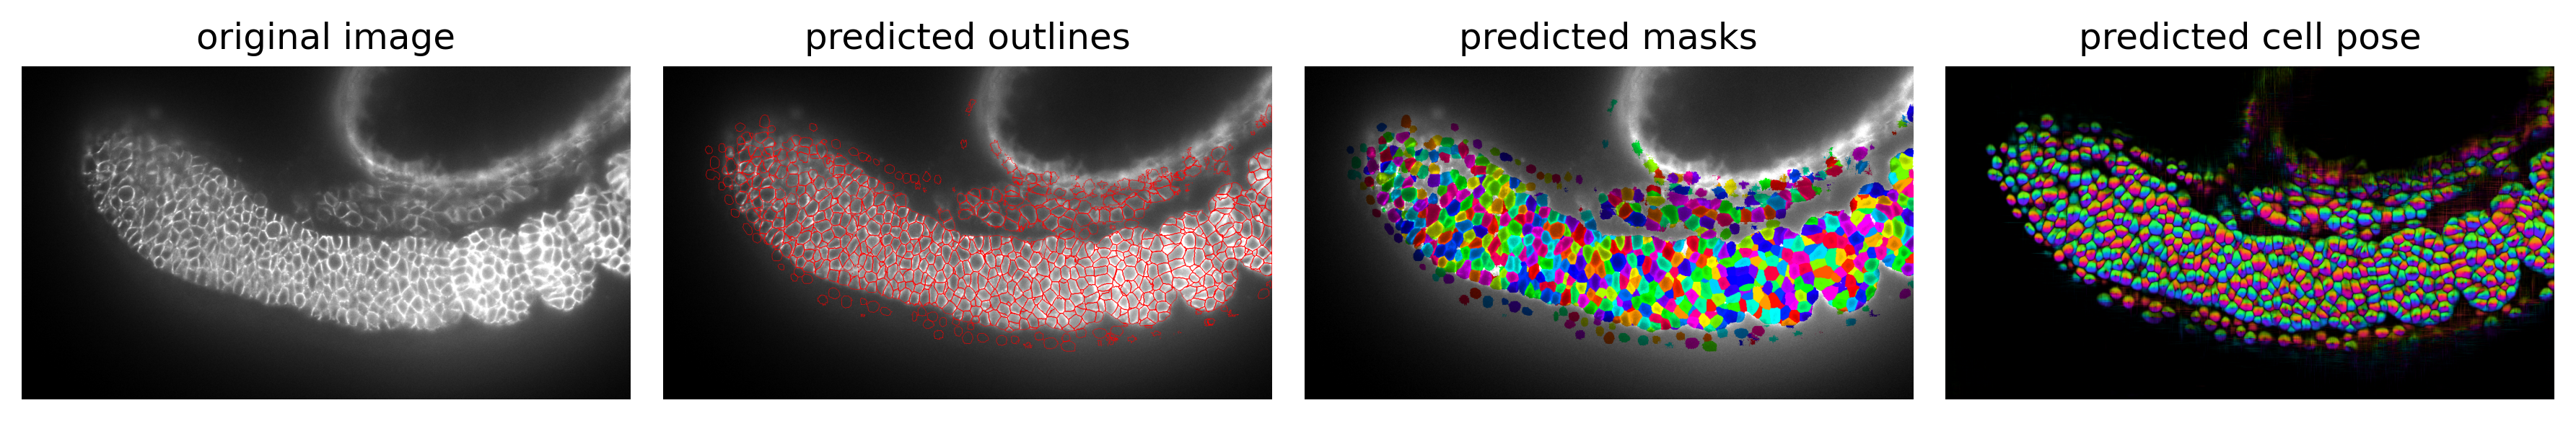

In [121]:
# display results
stack = 100

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, imgs[stack][0], masks[stack], flows[0][stack], channels=channels)
plt.tight_layout()
plt.show()



## Postprocessing

In [123]:
# check out 
# https://www.napari-hub.org/plugins/napari-pyclesperanto-assistant and 
# https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/18_image_filtering/03_background_removal.html